# Police Dataset 🚨👮🏻‍♀️🚔🚨

### What do we want to extract from this data?

Questions to Answer:

1. Does the outcomes of the police stop reflects appropriate penalties for the given violation?
2. Does the police have any bias towards any group?

In [5]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
csv_path = "../data/police.csv"
df = pd.read_csv(csv_path)
df.fillna("NA")
df.head()

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [7]:
df.search_type = df.search_type.fillna("none")
df.search_type.unique()

array(['none', 'Incident to Arrest,Protective Frisk', 'Probable Cause',
       'Incident to Arrest', 'Probable Cause,Reasonable Suspicion',
       'Incident to Arrest,Inventory,Probable Cause',
       'Incident to Arrest,Inventory',
       'Incident to Arrest,Probable Cause', 'Protective Frisk',
       'Reasonable Suspicion', 'Inventory', 'Inventory,Protective Frisk',
       'Incident to Arrest,Reasonable Suspicion',
       'Incident to Arrest,Probable Cause,Protective Frisk',
       'Probable Cause,Protective Frisk',
       'Incident to Arrest,Inventory,Protective Frisk',
       'Protective Frisk,Reasonable Suspicion',
       'Incident to Arrest,Inventory,Reasonable Suspicion',
       'Inventory,Probable Cause',
       'Incident to Arrest,Protective Frisk,Reasonable Suspicion',
       'Inventory,Probable Cause,Protective Frisk',
       'Inventory,Reasonable Suspicion',
       'Incident to Arrest,Probable Cause,Reasonable Suspicion',
       'Inventory,Probable Cause,Reasonable Suspicio

In [8]:
display(df.describe())
display(df.describe(include='O'))

,county_name,driver_age_raw,driver_age
count,0.0,86414.000000,86120.000000
mean,NaN,1970.491228,34.011333
std,NaN,110.914909,12.738564
min,NaN,0.000000,15.000000
25%,NaN,1967.000000,23.000000
50%,NaN,1980.000000,31.000000
75%,NaN,1987.000000,43.000000
max,NaN,8801.000000,99.000000


,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_type,stop_outcome,is_arrested,stop_duration
count,91741,91741,86406,86408,86408,86408,91741,86408,86408,86408
unique,3768,1436,2,5,12,6,25,6,2,5
top,2012-01-11,11:00,M,White,Speeding,Speeding,none,Citation,False,0-15 Min
freq,69,323,62895,62158,48463,48463,88545,77006,83479,69543


In [9]:
df.search_type.value_counts(dropna=False)

search_type
none                                                        88545
Incident to Arrest                                           1219
Probable Cause                                                891
Inventory                                                     220
Reasonable Suspicion                                          197
Protective Frisk                                              161
Incident to Arrest,Inventory                                  129
Incident to Arrest,Probable Cause                             106
Probable Cause,Reasonable Suspicion                            75
Incident to Arrest,Inventory,Probable Cause                    34
Probable Cause,Protective Frisk                                33
Incident to Arrest,Protective Frisk                            33
Inventory,Probable Cause                                       22
Incident to Arrest,Reasonable Suspicion                        13
Incident to Arrest,Inventory,Protective Frisk                  1

In [10]:
df.search_type.dropna().apply(lambda x: x.split(',')).explode().value_counts()

search_type
none                    88545
Incident to Arrest       1566
Probable Cause           1182
Inventory                 439
Reasonable Suspicion      314
Protective Frisk          274
Name: count, dtype: int64

In [11]:
print("Violations:")
print(df.violation.unique())
print("Stop Outcomes:")
print(df.stop_outcome.unique())
print("Stop Durations:")
print(df.stop_duration.unique())
print("Search Conducted:")
print(df.search_conducted.unique())

Violations:
['Speeding' 'Other' 'Equipment' 'Moving violation' nan
 'Registration/plates' 'Seat belt']
Stop Outcomes:
['Citation' 'Arrest Driver' nan 'N/D' 'Warning' 'Arrest Passenger'
 'No Action']
Stop Durations:
['0-15 Min' '16-30 Min' '30+ Min' nan '2' '1']
Search Conducted:
[False  True]


In [12]:
# Treating Nulls

cleaned_df = df.copy()

# TODO: Apply PMM
cleaned_df["driver_age"] = cleaned_df.driver_age.fillna(0.0)
cleaned_df["is_arrested"] = cleaned_df.is_arrested.fillna(False)

## Some More Features ⚙️ 👷‍♀️

In [13]:
def stop_outcome_level(row):
  '''
  stop_outcome_level - creates a feature that qantifies the gravity level of the
  stop outcome. The higher the level means worse outcome.
  Will follow the rule:
  5. Arrest Driver
  4. Arrest Passenger
  3. Citation
  2. Warning
  1. N/D | No Action | any other
  '''
  stop_outcome_level = 1
  if row.stop_outcome == "Arrest Driver":
    stop_outcome_level = 5
  elif row.stop_outcome == "Arrest Passenger":
    stop_outcome_level = 4
  elif row.stop_outcome == "Citation":
    stop_outcome_level = 3
  elif row.stop_outcome == "Warning":
    stop_outcome_level = 2

  return stop_outcome_level

def violation_level(row):
  '''
  violation_level - creates a feature that quantifies the gravity level of the
  violation commited. The higher the level means worse violation.
  Will follow the rule:
  5. Speeding
  4. Moving Violation
  3. Seat Belt
  2. Registration/plates
  1. any other
  '''
  violation_level = 1
  if row.violation == "Speeding":
    violation_level = 5
  elif row.violation == "Moving Violation":
    violation_level = 4
  elif row.violation == "Seat Belt":
    violation_level = 3
  elif row.violation == "Registration/plates":
    violation_level = 2

  return violation_level


def stop_time_discretization(row):
  '''
  stop_time_discretization - quantifies hour
  '''
  hour_min = row.stop_time.split(":")
  stop_time_discrete = int(hour_min[0] + hour_min[1])
  return stop_time_discrete



In [14]:
featured_df = cleaned_df.copy()
featured_df["stop_outcome_level"] = featured_df.apply(stop_outcome_level, axis="columns")
featured_df["violation_level"] = featured_df.apply(violation_level, axis="columns")
'''
proportinal_stop_outcome: measures the proportion of the outcome level with the violation level
pso = 1: equaly proportional
pso > 1: disproportionally greater
pso < 1: disproportionally lower
'''
featured_df["proportional_stop_outcome"] = featured_df["stop_outcome_level"] / featured_df["violation_level"]
featured_df["stop_time_discrete"] = featured_df.apply(stop_time_discretization, axis="columns")
featured_df["is_black_or_hispanic"] = featured_df.apply(
    lambda row: row.driver_race == "Black" or row.driver_race == "Hispanic",
    axis="columns"
)

featured_df["stop_time_discrete_bins"] = pd.cut(
    featured_df["stop_time_discrete"],
    4,
    labels=["dawn", "morning", "evening", "night"]
)

featured_df["driver_age_bins"] = pd.cut(
    featured_df["driver_age"],
    4,
    labels=["jovem", "adulto", "meia_idade", "idoso"]
)

'''
counter - column to make counting operations easier
'''
featured_df["counter"] = 1

featured_df.head()

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,...,stop_duration,drugs_related_stop,stop_outcome_level,violation_level,proportional_stop_outcome,stop_time_discrete,is_black_or_hispanic,stop_time_discrete_bins,driver_age_bins,counter
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,155,False,dawn,jovem,1
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,815,False,morning,adulto,1
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,2315,False,night,adulto,1
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,...,16-30 Min,False,5,1,5.0,1715,False,evening,jovem,1
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,1000,False,morning,jovem,1


## Simple Exploratory Analysis 🗺️

In [15]:
featured_df.groupby("driver_gender").describe()

county_name                              driver_age_raw  \
                    count mean std min 25% 50% 75% max          count   
driver_gender                                                           
F                     0.0  NaN NaN NaN NaN NaN NaN NaN        23510.0   
M                     0.0  NaN NaN NaN NaN NaN NaN NaN        62895.0   

                            ... stop_time_discrete          counter            \
                      mean  ...                75%     max    count mean  std   
driver_gender               ...                                                 
F              1974.766610  ...             1620.0  2359.0  23511.0  1.0  0.0   
M              1968.954718  ...             1639.0  2359.0  62895.0  1.0  0.0   

                                        
               min  25%  50%  75%  max  
driver_gender                           
F              1.0  1.0  1.0  1.0  1.0  
M              1.0  1.0  1.0  1.0  1.0  

[2 rows x 64 columns]

<Axes: xlabel='driver_gender'>

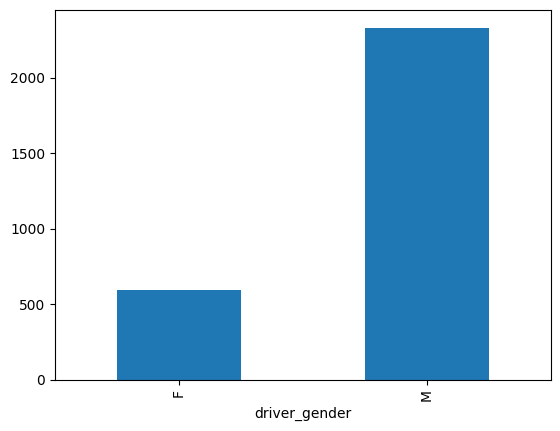

In [16]:
featured_df[featured_df.is_arrested == True].groupby("driver_gender")["counter"].count().plot(kind="bar")

In [17]:
# featured_df.proportional_stop_outcome.plot.bar(figsize=(4, 4), legend=False)

## More Exploratory Analysis 🧭🗺️

In [18]:
featured_df.describe()

,county_name,driver_age_raw,driver_age,stop_outcome_level,violation_level,proportional_stop_outcome,stop_time_discrete,counter
count,0.0,86414.000000,91741.000000,91741.000000,91741.000000,91741.000000,91741.000000,91741.0
mean,NaN,1970.491228,31.927448,2.860281,3.150445,1.540728,1194.606861,1.0
std,NaN,110.914909,14.793998,0.661906,1.966006,1.181678,651.307607,0.0
min,NaN,0.000000,0.000000,1.000000,1.000000,0.200000,0.000000,1.0
25%,NaN,1967.000000,22.000000,3.000000,1.000000,0.600000,810.000000,1.0
50%,NaN,1980.000000,29.000000,3.000000,5.000000,0.600000,1140.000000,1.0
75%,NaN,1987.000000,42.000000,3.000000,5.000000,3.000000,1635.000000,1.0
max,NaN,8801.000000,99.000000,5.000000,5.000000,5.000000,2359.000000,1.0


In [19]:
# Defining baseline features for comparison

baseline_features = [
    "is_arrested",
    "driver_race",
    "driver_gender",
    "stop_outcome_level",
    "violation_level",
    "search_conducted",
    "search_type",
    "drugs_related_stop",
    "stop_time_discrete_bins",
    "driver_age_bins",
]

In [20]:
def box_plot_by(df_, col):
  box = df_.copy()
  fig_size = (8, 10)

  plt.figure(figsize=fig_size)

  ax = box.boxplot(
      by=col,
      column='stop_outcome_level',
  )

  ax.set_xlabel('')
  ax.set_ylabel('Stop Outcome Level (arrested, warning, citation...)')
  plt.suptitle('Outcome Level by ' + col)

  bx = box.boxplot(
      by=col,
      column='violation_level',
  )
  bx.set_xlabel('')
  bx.set_ylabel('Violation Level (Speed, moving violation, ....)')
  plt.suptitle('Violation Level by ' + col)

### By Gender 🤷🏻‍♂️ 🤷🏽‍♀️

In [21]:
df_by_gender = featured_df.copy()
df_by_gender = featured_df.groupby("driver_gender")

In [22]:
df_by_gender.count()

,stop_date,stop_time,county_name,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,...,stop_duration,drugs_related_stop,stop_outcome_level,violation_level,proportional_stop_outcome,stop_time_discrete,is_black_or_hispanic,stop_time_discrete_bins,driver_age_bins,counter
driver_gender,,,,,,,,,,,,,,,,,,,,,
F,23511,23511,0,23510,23511,23511,23511,23511,23511,23511,...,23511,23511,23511,23511,23511,23511,23511,23511,23511,23511
M,62895,62895,0,62895,62895,62895,62895,62895,62895,62895,...,62895,62895,62895,62895,62895,62895,62895,62895,62895,62895


In [23]:
df_by_gender.violation.value_counts()

driver_gender  violation          
F              Speeding               15482
               Moving violation        3204
               Equipment               2487
               Registration/plates     1013
               Other                    690
               Seat belt                635
M              Speeding               32979
               Moving violation       13020
               Equipment               8533
               Other                   3627
               Registration/plates     2419
               Seat belt               2317
Name: count, dtype: int64

## Correlations =

### Mutual Information

In [24]:
X = featured_df.copy()
X = X[baseline_features]
y = X.pop("stop_outcome_level")

TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

In [ ]:
# label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

X["stop_time_discrete_bins"], _ = X["stop_time_discrete_bins"].factorize()
X["driver_age_bins"], _ = X["driver_age_bins"].factorize()

discrete_features = X.dtypes == int

display(X.head())
display(X["stop_time_discrete_bins"].dtype)

,is_arrested,driver_race,driver_gender,violation_level,search_conducted,search_type,drugs_related_stop,stop_time_discrete_bins,driver_age_bins
0,False,0,0,5,False,0,False,0,0
1,False,0,0,5,False,0,False,1,1
2,False,0,0,5,False,0,False,2,1
3,True,0,0,1,False,0,False,3,0
4,False,0,1,5,False,0,False,1,0


dtype('int64')

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')


In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(
        X,
        y,
        discrete_features=discrete_features,
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3] # show few features with their scores

In [ ]:

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
# Correlationa

X_y = X.copy()
X_y["stop_outcome_level"] = y

plt.rcParams["figure.figsize"] = (8,8)
sns.heatmap(
    X_y.corr(),
    vmin=-1,
    vmax=1,
    cmap=sns.diverging_palette(20, 220, as_cmap=True)
)

## Using Decision Tree 🌲🌳

Using decision tree to understand how the most important feature values correlates with the stop outcome level.

In [ ]:
from sklearn import tree
from matplotlib import pyplot as plt

selected_features = [
    "driver_race",
    "driver_gender",
    "driver_age_bins",
    "violation_level",
    #"is_black_or_hispanic",
]
X_tree = featured_df.copy()
y_tree = X_tree.pop("is_arrested")
X_tree = pd.get_dummies(
    X_tree[selected_features],
    drop_first=False
)

for col in X_tree.columns:
  display(print(f"{col}: {X_tree[col].hasnans}"))

display(print(f"Y => {y_tree.hasnans}"))

#X_ = X.copy()
#y_ = X_.pop("is_arrested")
#X_ = X_[selected_features]


clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_tree, y_tree)


In [ ]:
#plt.rcParams["figure.figsize"] = (30,30)
#plt.rcParams["figure.figsize"] = (10,10)
tree.plot_tree(clf, feature_names=X_tree.columns, fontsize=5)
plt.figure(dpi=100, figsize=(10, 10))
plt.show()

## Linear Regression Coeficient Analysis 📈🧪

In [ ]:
# creating lm dataset
X_lm = featured_df.copy()
y_lm = X_lm.pop("stop_outcome_level")

# selecting lm features
lm_features = [
    "driver_race",
    "driver_gender",
    "driver_age_bins",
    "violation_level",
    "search_conducted",
    "drugs_related_stop",
]

for bool_col in ["search_conducted", "drugs_related_stop"]:
  X_lm[bool_col] = X_lm[bool_col].astype("str")

# getting categorical features dummies
X_lm = pd.get_dummies(X_lm[lm_features], drop_first=False)

X_lm.head()

In [ ]:
from sklearn.linear_model import LinearRegression

police_stop_lm = LinearRegression()
police_stop_lm.fit(X_lm, y_lm)

print(f"Intercept: {police_stop_lm.intercept_:.3f}")
print(f"Coefficients: ")
for name, coef in zip(X_lm.columns, police_stop_lm.coef_):
    print(f" {name}: {coef}")


In [ ]:
from statsmodels.regression.linear_model import OLS

model = OLS(y_lm, X_lm.assign(const=1))
results = model.fit()
results.summary()

## K-Means To Create Clusters ☯️

In [ ]:
X_kmeans = X.copy()

X_kmeans.head()

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters)
X_kmeans["cluster"] = kmeans.fit_predict(X)
X_kmeans["cluster"] = X_kmeans["cluster"].astype("category")

X_kmeans.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,is_arrested,driver_race,driver_gender,violation_level,search_conducted,search_type,drugs_related_stop,stop_time_discrete_bins,driver_age_bins,cluster
0,False,0,0,5,False,0,False,0,0,3
1,False,0,0,5,False,0,False,1,1,3
2,False,0,0,5,False,0,False,2,1,0
3,True,0,0,1,False,0,False,3,0,4
4,False,0,1,5,False,0,False,1,0,3


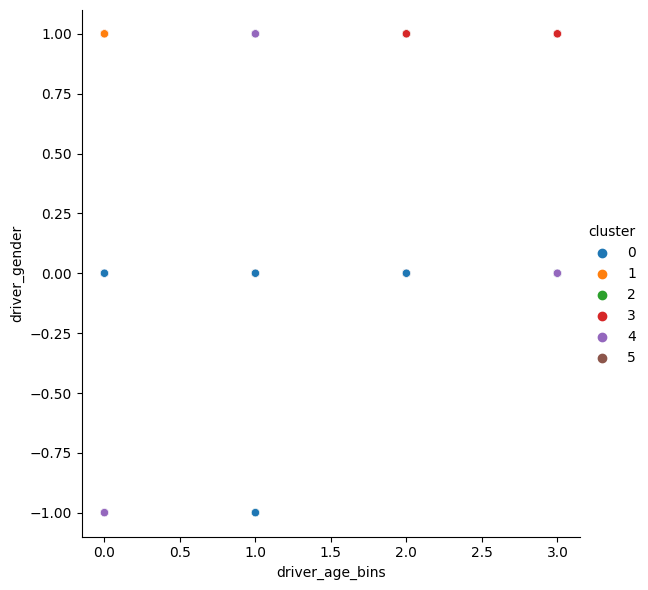

In [ ]:
sns.relplot(
    x='driver_age_bins',
    y='driver_gender',
    hue='cluster',
    data=X_kmeans,
    height=n_clusters,
)

## Hypothesis